Author: Hem N Chaudhary

Date: Jan, 2024

Description: Extractive Question Answering with Transformers

**Building a Review-Based QA System**

In [ ]:
! pip install datasets

In [ ]:
#using SubjQA dataset , looking at subsets

from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
#focusing on electronics domain

from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [ ]:
#inspecting one of the rows in the answers column

print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [ ]:
#flattening the nested columns to explore dataset more easily

import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [ ]:
#looking at a few of the tranining examples

qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [ ]:
#using start index and length of the answer span to slice out the span of text in the review that correspinds to the answer

start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

In [ ]:
import matplotlib.pyplot as plt

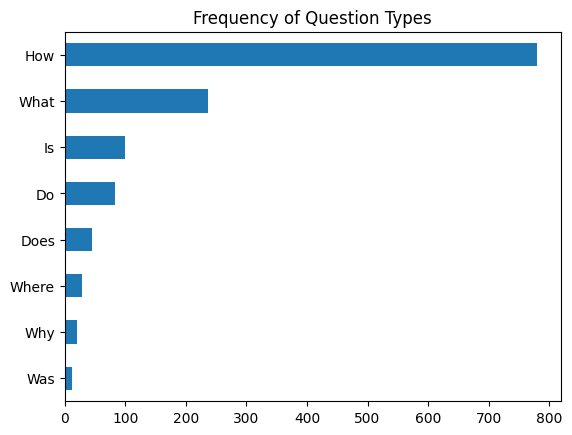

In [ ]:
#get a feel for what types of questions are in the training set by counting the questions that begin with a few common starting words

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [ ]:
#look at some examples

for question_type in ["How", "What", "Is"]:
  for question in (
      dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)['question']):
    print(question)


How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


**Extracting Answers from Text**

In [ ]:
#using fine-tuned MiniLM

from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
#model in action

question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \ file size."""

inputs = tokenizer(question, context, return_tensors="pt")

In [ ]:
#tokenizer formating the inputs for QA tasks

print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on \ file size. [SEP]


In [ ]:
#!pip install protobuf

In [ ]:
#instantiating the model with a QA head and run the inputs

import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.7600, -4.7565, -5.4027, -5.2368, -5.2771, -5.4985, -4.9769, -6.1621,
         -0.7600,  0.6527,  0.0474, -1.4596,  4.0708,  5.2617, -0.7022, -3.8406,
         -1.4190, -4.6270, -1.4310,  3.7721,  4.5929, -0.3631, -3.3237, -5.1965,
         -3.1124, -3.4640, -4.2704, -4.4887, -0.7600]]), end_logits=tensor([[-0.7715, -5.4826, -5.0251, -5.1502, -5.4228, -5.5347, -5.1739, -4.6997,
         -0.7715, -3.6354, -0.5732, -3.6876, -2.8507, -0.8947,  0.6139, -2.4160,
          5.4288,  0.2895, -3.0944, -3.3933,  0.7722,  5.4368, -0.8595, -5.0447,
         -4.4632, -4.1436, -1.1829, -0.3302, -0.7715]]), hidden_states=None, attentions=None)


In [ ]:
#getting the logits for start and end tokens

start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [ ]:
#comparing the shapes of these logits to the input IDs
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 29])
Start logits shape: torch.Size([1, 29])
End logits shape: torch.Size([1, 29])


In [ ]:
#getting final answer by computing the argmax over the start and end token logits and thenslice the span from the inputs
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 1 mb / minute, so about 6000 hours


In [ ]:
#!pip install tensorflow_probability==0.12.2

In [ ]:
#wrapper for above steps

from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.23802025616168976,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.2361302375793457,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'},
 {'score': 0.12195158004760742,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'}]

In [ ]:
#case of empty answers.answer_start

pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.9193894863128662, 'start': 0, 'end': 0, 'answer': ''}

In [ ]:
#sliding windo for longer context;

example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], return_overflowing_tokens=True,
                              max_length=100, stride=25)




Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
#input_ids, one for each window

for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [ ]:
#seeing where two windows overlap by decoding

for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



In [ ]:
# ! pip install --upgrade pip
# ! pip install 'farm-haystack[all]

In [ ]:
#Haystack to build a QA Pipeline

#downloading and installing elastic search

url = """https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [ ]:
#starting Elasticsearch server

import os
from subprocess import Popen, PIPE, STDOUT

#Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1)) # Wait until Elasticsearch has started
!sleep 30

In [ ]:
#testing the connection by sending HTTPS request to localhost

!curl -X GET "localhost:9200/?pretty"

{
  "name" : "1b37cf0a8435",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "YYQQsYx8Ri-ez2Wai1vW5Q",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
!pip install farm-haystack[colab,preprocessing,elasticsearch,inference]


In [ ]:
from haystack.telemetry import send_event

In [ ]:
from haystack.document_stores import ElasticsearchDocumentStore
# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [ ]:
#included item_id, q_review_id, can filter by product and question ID along with coresp training split
#loop through the examples in each DataFrame and add them to the index with write_documents()

for split, df in dfs.items():
  #Exclude duplicate reviews
  docs = [{"content": row["context"],
           "meta": {"item_id": row["title"], "question_id": row["id"],
                    "split": split}}
          for _,row in df.drop_duplicates(subset="context").iterrows()]
  document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


In [ ]:
!pip install farm-haystack

In [ ]:
#Initializing retriver; BM25
#from haystack.retriever.sparse import ElasticsearchRetriever
from haystack.nodes import BM25Retriever

es_retriever = BM25Retriever(document_store=document_store)

#es_retriever = ElasticsearchRetriever(document_store=document_store)

In [ ]:
#product ASIN codes

item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [ ]:
#looking at the retrieved documents

print(retrieved_docs)

[<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}>, <Document: {'content': 'Plays Netflix great, WiFi capability has great range. Resolution on the screen is AMAZING! For the price you cannot go wrong. Bought one for my spouse and myself after becoming addicted to hers! Our son LOVES it an

In [ ]:
#initializing a reader; FARMReader

from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=True,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)



Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  1.37 Batches/s]

{'query': 'How much music can this hold?', 'no_ans_gap': 12.229926109313965, 'answers': [<Answer {'answer': '1 MB/minute, so about 6000 hours', 'type': 'extractive', 'score': 0.4859601855278015, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on \\ file size.', 'offsets_in_document': [{'start': 16, 'end': 48}], 'offsets_in_context': [{'start': 16, 'end': 48}], 'document_ids': ['697f6abf4828aa51d34e58ddc4b639b4'], 'meta': {}}>]}


In [ ]:
#putting it all together

from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [ ]:
#get it runnning

n_answers = 3
params={"Retriever": {"top_k": 3, "filters":{"item_id":[item_id], "split":["train"]}}, "Reader": {"top_k": n_answers}}
preds = pipe.run(query=query, params=params)


#print(preds[1]['answer'])

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 11.39 Batches/s]


In [ ]:
print(f"Question: {preds['query']} \n")

preds=[x.to_dict() for x in preds["answers"]]
for idx in range(n_answers):
  print(f"Answer {idx+1}: {preds[idx]['answer']}")
  print(f"Review snippet: ...{preds[idx]['context']}...")
  print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





**Evaluating the Retriever**

In [ ]:
#evaluating is same as a DocumentSearchPipeline

from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(es_retriever)



In [ ]:
# creating query and label

from haystack import Label, Answer, Document

labels =[]

for i, row in dfs["test"].iterrows():
  #Metada used for filtering in the Retriever
  meta = {"item_id": row["title"], "question_id": row["id"]}
  #populate labels for questions with answers
  if len(row["answers.text"]):
    for answer in row["answers.text"]:
      label = Label(
          query=row["question"], answer=Answer(answer=answer), origin="gold-label",
          document=Document(content=row["context"], id=row["review_id"]),
          meta=meta, is_correct_answer=True, is_correct_document=True,
          no_answer=False, filters={"item_id":[meta["item_id"]], "split":["test"]})
      labels.append(label)
  #Populate labels for questions without answers
  else:
    label = label = Label(
          query=row["question"], answer=Answer(answer=""), origin="gold-label",
          document=Document(content=row["context"], id=row["review_id"]),
          meta=meta, is_correct_answer=True, is_correct_document=True,
          no_answer=False, filters={"item_id":[meta["item_id"]], "split":["test"]})
    labels.append(label)

In [ ]:
#peek at one of these labels:
print(labels[5])

<Label: {'id': '3c13644d-b8f6-4fc8-b0bb-0511d3c2dd6e', 'query': 'Is the cord safe to grab the transformer?', 'document': {'id': '3c0a24c40d9d95f559e5ec923dd384bf', 'content': "After being disappointed by a $50 pair of Sony headphones, I snagged these Audio-Technica's based on the reviews here on Amazon. I'm very impressed with the quality of these headphones. The cord is very long and durable, the jack is strong and well constructed. The headphones themselves are very comfortable, block out a ton of background noise, and aren't too bulky or heavy. They're very durable and can take a beating.The sound quality for a non-amplified pair of headphones is nothing short of amazing. The majority of headphones in this price range are boomy, obnoxious headphones with poor midrange and high end performance. The ATH-M30 is incredibly well balanced with heavy lows, comfortable mids, and stunningly clear highs. I can't recommend a better pair of headphones in this price range.", 'content_type': 'tex

In [ ]:
#writing them to the label index on Elasticsearch
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} question-answer pairs """)

Loaded 910 question-answer pairs 


In [ ]:
#building up a mapping between our question IDs and corresponding answers
#using get_all_labels_aggregated() method that will aggregate q-a associated with a unique ID

labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))


330


In [ ]:
#peeking at one of the labels

print(labels_agg[109].answers)

['the fan is really really good', 'this cooler fits it just about perfectly', "the fan itself isn't super loud. There is an adjustable dial to change fan speed"]


In [ ]:
#feed each q-a pair associated with each product to the evaluation pipeline and track the corret retrieval

eval_result = pipe.eval(labels=labels_agg,
                        params={"Retriever": {"top_k": 3}},)
metrics = eval_result.calculate_metrics()

In [ ]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.95


In [ ]:
#checking the predictions of any query by inspecting the dataframe

eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,document_id,gold_document_ids,gold_id_match
3,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,3566c491f5aafe80a22667754727dfc0,[fac2e8bec06035a70307dd1e8034ea63],0.0
4,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,d5c7736727a38c2fe62df10beef4a5ce,[fac2e8bec06035a70307dd1e8034ea63],0.0
8,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,ebfb4b46819be7c051b27f0c28efd0fb,[],0.0
9,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,94163306f4c5c35c83ed165b2282cd32,[],0.0
10,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,7f5d77178fe93006124f731249d245f8,[],0.0
133,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,11818a689fbac56cbb063eb658b22c05,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62c...",0.0


In [ ]:
#recall over several top_k values

def evaluate_retriever(retriever, topk_values=[1,3,5,10,20]):
  topk_results ={}

  #Calculate max top_k
  max_top_k=max(topk_values)
  #Create Pipeline
  p=DocumentSearchPipeline(retriever)
  #Run inference with max top_k by looping over each q-a pair in the test set
  eval_result = p.eval(
      labels=labels_agg,
      params={"Retriever": {"top_k": max_top_k}},
  )
  #Calculate metric for each top_k value
  for topk in topk_values:
    #Get metrics
    metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
    topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

  return pd.DataFrame.from_dict(topk_results, orient="index")

bm25_topk_df = evaluate_retriever(es_retriever)

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a c

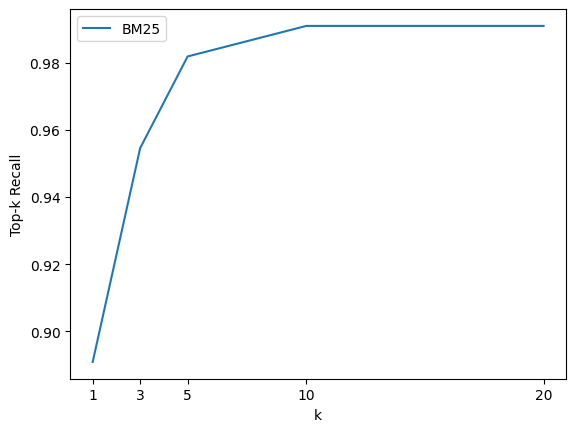

In [ ]:
#plotting the results as a fn of top_k

def plot_retriever_eval(dfs, retriever_names):
  fig, ax = plt.subplots()
  for df, retriever_name in zip(dfs, retriever_names):
    df.plot(y="recall", ax=ax, label=retriever_name)
  plt.xticks(df.index)
  plt.ylabel("Top-k Recall")
  plt.xlabel("k")
  plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

**Dense Passage Retrieval**

In [ ]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
#iterating over all the indexed documents in the Elasticsearch index and apply encoders
document_store.update_embeddings(retriever=dpr_retriever)

Create embeddings: 100%|██████████| 1616/1616 [00:21<00:00, 73.14 Docs/s]
Updating embeddings: 10000 Docs [00:33, 302.45 Docs/s]


/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a c

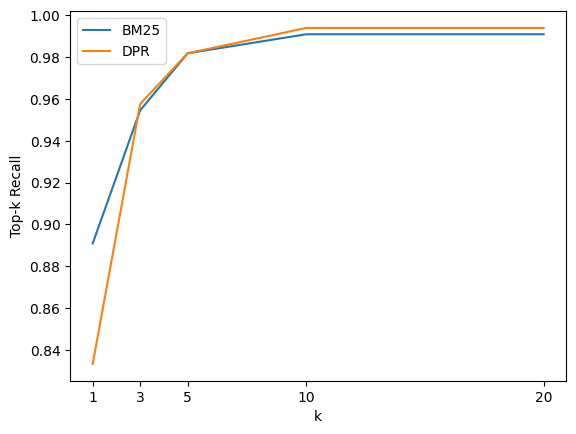

In [ ]:
#evaluating the dense retriever

dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

**Evaluating the Reader**

In [ ]:
#working of f1 and exact match

from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"

print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [ ]:
#testing their limits
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [ ]:
#read evaluation pipeline consisting of a single node(a reader)

from haystack.pipelines import Pipeline

def evaluate_reader(reader):
  score_keys = ["exact_match", "f1"]
  p=Pipeline()
  p.add_node(component=reader, name="Reader", inputs=["Query"])

  eval_result = p.eval(
      labels=labels_agg,
      documents = [[label.document for label in multilabel.labels] for multilabel in labels_agg],
      params ={}
  )
  metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

  return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 49.32 Batches/s]


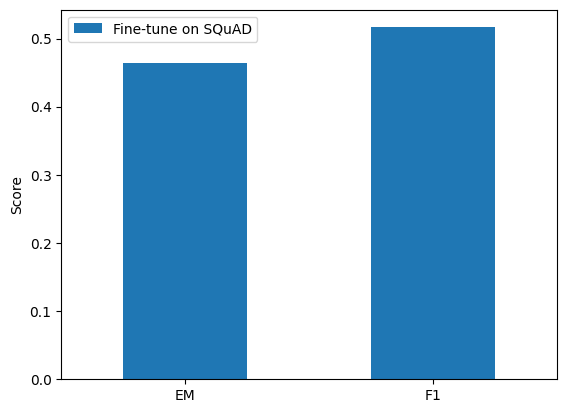

In [ ]:
#plotting the scores
def plot_reader_eval(reader_eval):
  fig, ax = plt.subplots()
  df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
  df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
  ax.set_xticklabels(["EM", "F1"])
  plt.legend(loc='upper left')
  plt.show()

plot_reader_eval(reader_eval)

**Domain Adaptation**

In [ ]:
#SQuAD JASON format
#creating the paragraphs array associated with each product ID

def create_paragraphs(df):
  paragraphs = []
  id2context = dict(zip(df["review_id"], df["context"]))
  for review_id, review in id2context.items():
    qas = []
    #Filter for all question-answer pairs about a specific context
    review_df = df.query(f"review_id=='{review_id}'")
    id2question = dict(zip(review_df["id"], review_df["question"]))
    # Build up the qas array
    for qid, question in id2question.items():
      #Filter for a single question ID
      question_df = df.query(f"id=='{qid}'").to_dict(orient="list")
      ans_start_idxs = question_df["answers.answer_start"][0].tolist()
      ans_text = question_df["answers.text"][0].tolist()
      #Fill answerable questions
      if len(ans_start_idxs):
        answers = [{"text": text, "answer_start": answer_start}
            for text, answer_start in zip(ans_text, ans_start_idxs)]
        is_impossible = False
      else:
        answers = []
        is_impossible = True
      #Add question-answer-pairs to qas
      qas.append({"question": question, "id": qid,
                "is_impossible": is_impossible, "answers": answers })
    #Add context and question-answer pairs to paragraphs
    paragraphs.append({"qas":qas, "context": review})
  return paragraphs


In [ ]:
#peek at SQuAD format

product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [ ]:
#appyint the above fn to each product ID in the DataFrame of each split

import json

def convert_to_squad(dfs):
  for split, df in dfs.items():
    subjqa_data = {}
    #Create paragraphs for each product ID
    groups = (df.groupby("title").apply(create_paragraphs).to_frame(name="paragraphs").reset_index())
    subjqa_data["data"] = groups.to_dict(orient="records")
    #save the result to disk
    with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
      json.dump(subjqa_data, f)

convert_to_squad(dfs)

In [ ]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 49.06 Batches/s]


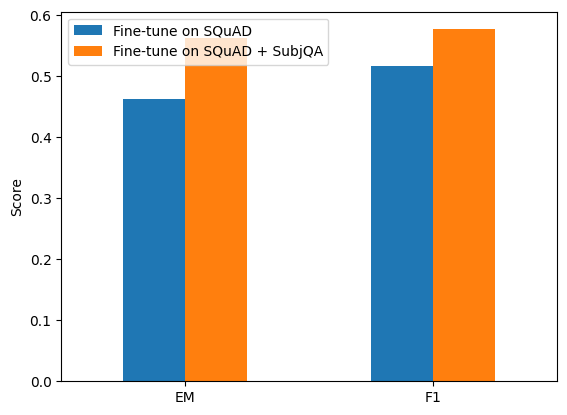

In [ ]:
#comparing its performance on the test set against the baseline model

reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [ ]:
#naive fine tuning of base model

minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
#Fine tuning one epoch
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
                    train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

In [ ]:
#evaluation on the test set
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

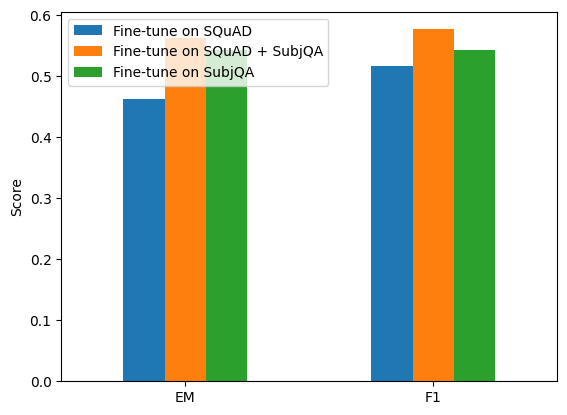

In [ ]:
#plots
plot_reader_eval(reader_eval)

**Evaluating the Whole QA Pipeline**

In [ ]:
#tieing retriever and reader together for evaluation

from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(retriever=es_retriever, reader=reader)

#Evaluate!

eval_result = pipe.eval(labels=labels_agg, params={})

metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

#Extract metrics from reader

reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items() if k in ["exact_match", "f1"]
}

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 65.70 Batches/s]


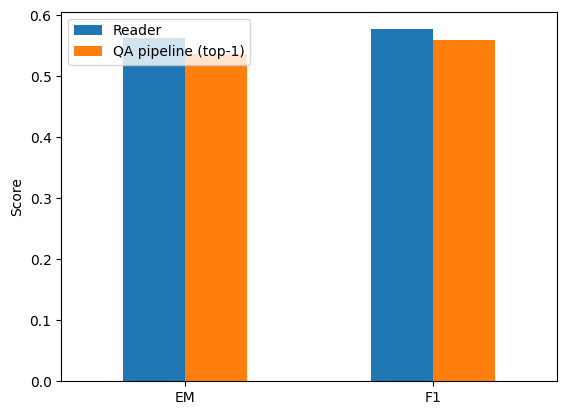

In [ ]:
#comparing top 1 EM and F1 socres for the models to predict answer

plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})



**Going Beyond Extractive QA**

In [ ]:
# !pip install --upgrade pip
# !pip install farm-haystack[colab,faiss]==1.17.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 46.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of azure-core to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.0 MB/s eta 0:

In [ ]:
from haystack.nodes import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

ImportError: cannot import name 'RAGenerator' from 'haystack.nodes' (/usr/local/lib/python3.10/dist-packages/haystack/nodes/__init__.py)

In [ ]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query,
                     params={"Retriever": {"top_k":5,
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

In [ ]:
generate_answers(query)

In [ ]:
generate_answers("What is the main drawback?")